## Распознавание лиц и эмоций
###Задание
Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать. Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель. Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Определение класса для загрузки данных
class LeapGestRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Проход по всем папкам и файлам в корневом каталоге данных
        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                for class_name in os.listdir(folder_path):
                    class_path = os.path.join(folder_path, class_name)
                    if os.path.isdir(class_path):
                        for file_name in os.listdir(class_path):
                            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                                self.image_files.append(os.path.join(class_path, file_name))
                                self.labels.append(class_name)

        # Проверка наличия изображений и меток
        assert len(self.image_files) > 0, "No images found in dataset"
        assert len(self.labels) > 0, "No labels found in dataset"

        # Создание словаря для преобразования меток в индексы
        self.label_to_index = {label: idx for idx, label in enumerate(set(self.labels))}
        self.label_to_index_inv = {idx: label for label, idx in self.label_to_index.items()}
        self.num_classes = len(self.label_to_index)
        self.labels = [self.label_to_index[label] for label in self.labels]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Определение модели жестов
class GestureCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GestureCNN, self).__init__()
        self.num_classes = num_classes  # Добавление атрибута num_classes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Изменено с 32 * 32 на 16 * 16
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Изменено с 32 * 32 на 16 * 16
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Загрузка предварительно обученной модели для детекции лиц
face_detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
face_detection_model.eval()
face_detection_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 52.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# Функция для детекции лиц
def detect_faces(image):
    # Определение преобразований для изображений лиц
    transform = transforms.Compose([transforms.ToTensor(),])
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = face_detection_model(image_tensor)
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    # Отбор только тех детекций, у которых confidence > 0.5
    boxes = [box for box, score in zip(boxes, scores) if score > 0.5]
    return boxes

In [6]:
# Создание модели для детекции лиц и классификации жестов
class FaceAndGestureModel(nn.Module):
    def __init__(self, gesture_model):
        super(FaceAndGestureModel, self).__init__()
        self.gesture_model = gesture_model

    def forward(self, image):
        boxes = detect_faces(image)
        results = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            face_image = image.crop((x1, y1, x2, y2))
            face_image = transform(face_image).unsqueeze(0).to(device)  # Применение преобразований
            with torch.no_grad():
                output = self.gesture_model(face_image)
            _, predicted = torch.max(output.data, 1)
            results.append(predicted.item())
        return results

In [7]:
# Определение преобразований изображений
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [8]:
import os

# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = '/path_to_kaggle_json'  # Set this if kaggle.json is not in default location

# Download the dataset
!kaggle datasets download -d gti-upm/leapgestrecog

# Unzip the dataset
!unzip leapgestrecog.zip


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [9]:
# Загрузка данных
data_dir = '/content/leapGestRecog'
train_dataset = LeapGestRecogDataset(data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [10]:
# Инициализация модели, критерия и оптимизатора
model = GestureCNN(num_classes=train_dataset.num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [11]:
# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Перемещение данных на выбранное устройство
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}')

    return loss_history

In [12]:
# Обучение модели
loss_history = train_model(model, train_loader, criterion, optimizer)

Epoch 1/15, Loss: 0.481706
Epoch 2/15, Loss: 0.026905
Epoch 3/15, Loss: 0.014048
Epoch 4/15, Loss: 0.008477
Epoch 5/15, Loss: 0.002515
Epoch 6/15, Loss: 0.004089
Epoch 7/15, Loss: 0.000180
Epoch 8/15, Loss: 0.000066
Epoch 9/15, Loss: 0.000044
Epoch 10/15, Loss: 0.000028
Epoch 11/15, Loss: 0.014965
Epoch 12/15, Loss: 0.000490
Epoch 13/15, Loss: 0.001088
Epoch 14/15, Loss: 0.000706
Epoch 15/15, Loss: 0.000038


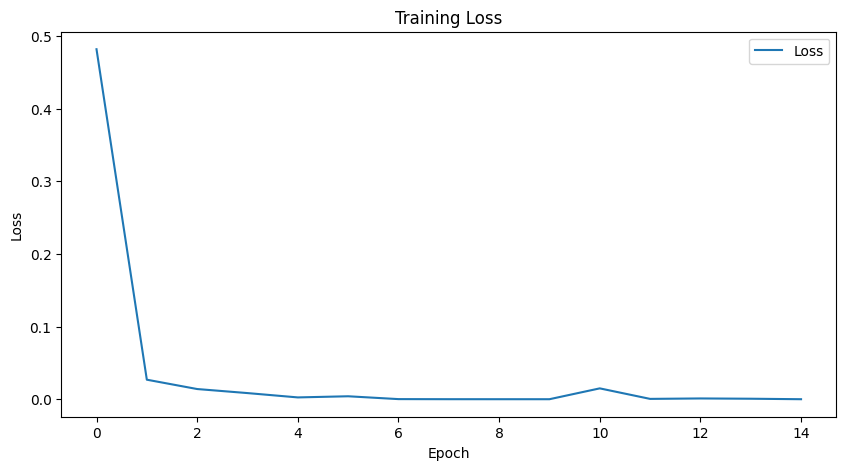

In [13]:
# Визуализация кривой потерь
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [14]:
# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Перемещение данных на выбранное устройство
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    return accuracy

In [15]:
# Загрузка тестовых данных
test_dataset = LeapGestRecogDataset(data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Тестирование модели
accuracy = test_model(model, test_loader)

# Создание словаря для преобразования индексов жестов в понятные названия
index_to_gesture = {v: k for k, v in train_dataset.label_to_index.items()}
print(index_to_gesture)

Accuracy: 100.00%
{0: '10_down', 1: '05_thumb', 2: '03_fist', 3: '01_palm', 4: '08_palm_moved', 5: '04_fist_moved', 6: '06_index', 7: '09_c', 8: '07_ok', 9: '02_l'}


In [16]:
# Визуализация примеров предсказаний
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)  # Перемещение данных на выбранное устройство
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(transforms.ToPILImage()(images[i].cpu()))  # Перемещение обратно на CPU для визуализации
        ax.set_title(f'Pred: {index_to_gesture[predicted[i].item()]}\nTrue: {index_to_gesture[labels[i].item()]}')
        ax.axis('off')

    plt.show()

In [17]:
def visualize_faces_and_gestures(image, model):
    # Определение преобразований для изображений лиц
    face_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Приведение изображения лица к нужному размеру
        transforms.ToTensor(),
    ])

    boxes = detect_faces(image)

    if not boxes:
        print("No faces detected.")
        return

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        face_image = image.crop((x1, y1, x2, y2))
        face_image = face_transform(face_image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(face_image)
        _, predicted = torch.max(output.data, 1)
        gesture_index = predicted.item()
        gesture = index_to_gesture[gesture_index]

        ax.text(x1, y1 - 10, f'Gesture: {gesture}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

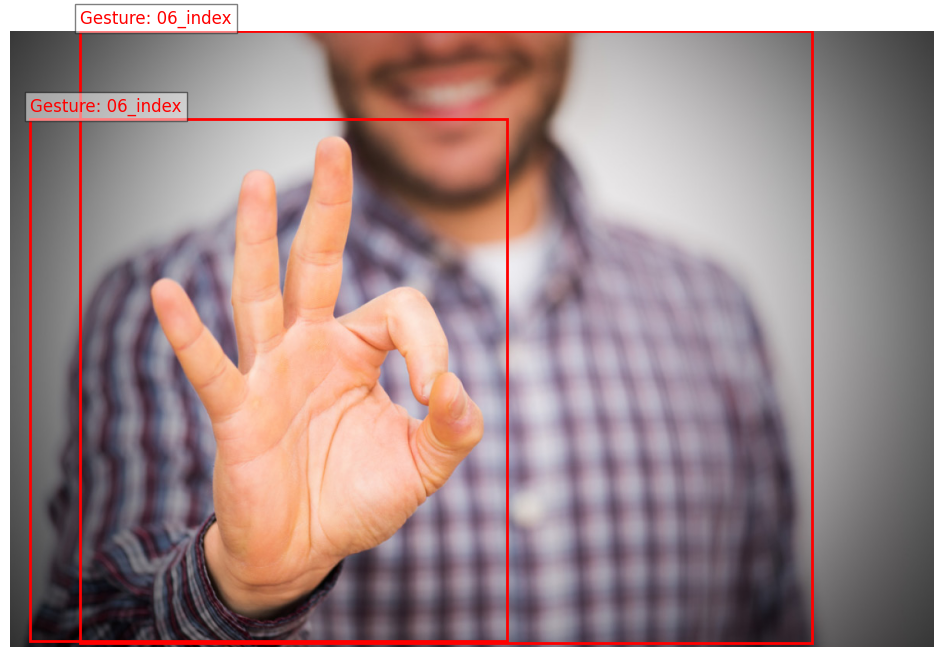

In [20]:
# Пример использования
# Загрузка примера изображения
example_image_path = '/content/b221ec2a14d743dc800869bb9ecdbdca.jfif'
example_image = Image.open(example_image_path).convert('RGB')

# Визуализация лиц и жестов на примере изображения
visualize_faces_and_gestures(example_image, model)

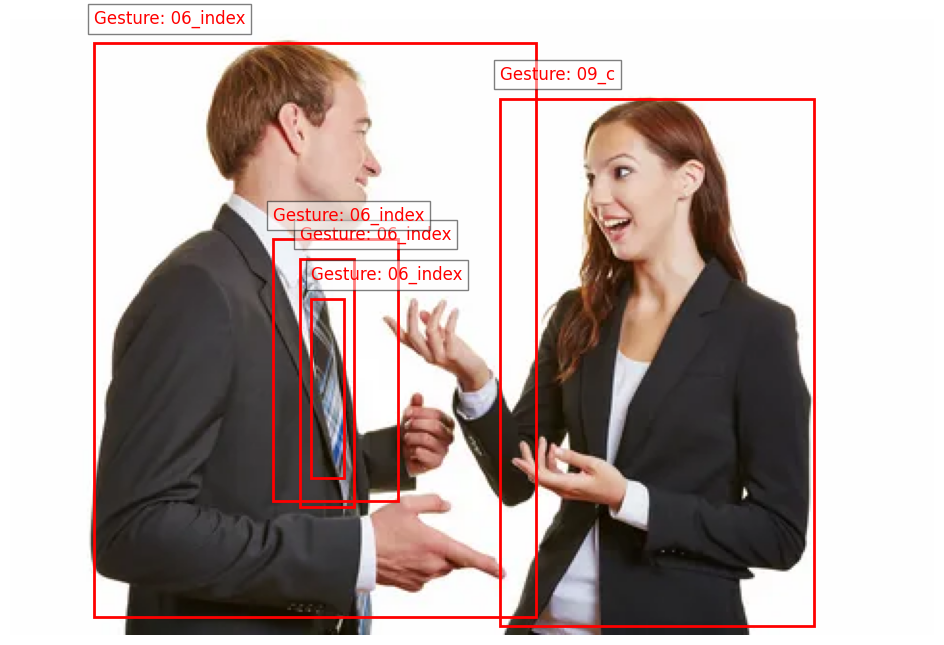

In [21]:
# Пример использования
# Загрузка примера изображения
example_image_path = '/content/i (2).webp'
example_image = Image.open(example_image_path).convert('RGB')

# Визуализация лиц и жестов на примере изображения
visualize_faces_and_gestures(example_image, model)

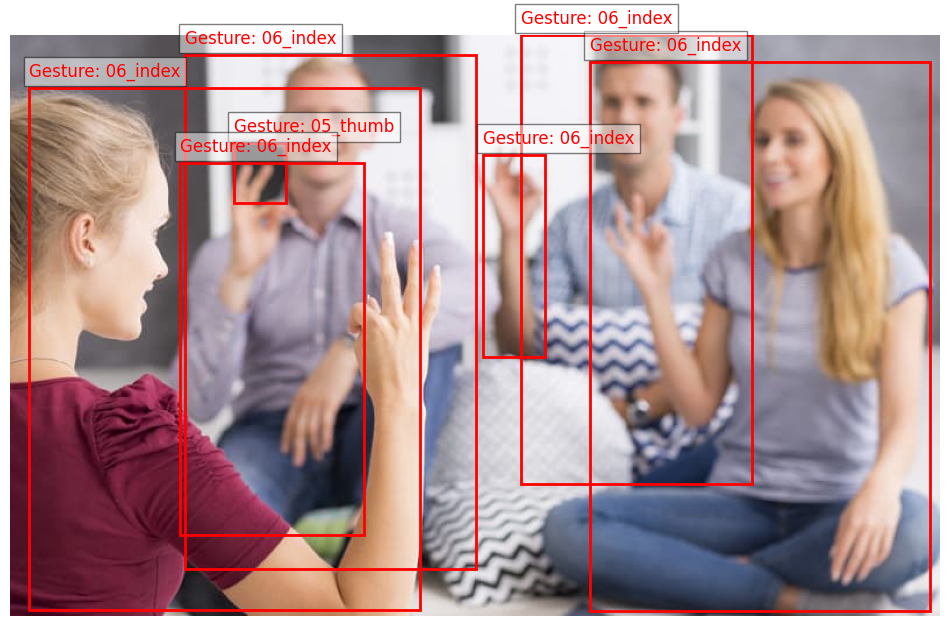

In [22]:
# Пример использования
# Загрузка примера изображения
example_image_path = '/content/a463049281ea9b26d76214795fa452a1.png'
example_image = Image.open(example_image_path).convert('RGB')

# Визуализация лиц и жестов на примере изображения
visualize_faces_and_gestures(example_image, model)

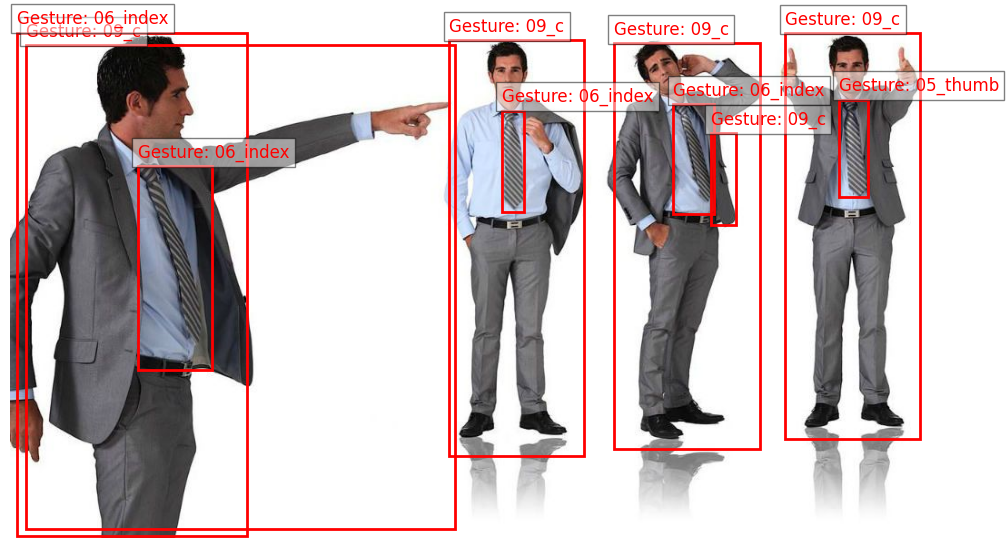

In [23]:
# Пример использования
# Загрузка примера изображения
example_image_path = '/content/7a227b1facf9488577571c248d841278.jpg'
example_image = Image.open(example_image_path).convert('RGB')

# Визуализация лиц и жестов на примере изображения
visualize_faces_and_gestures(example_image, model)

Из полученных результатов можно сделать выводы, что обученная модель, хоть и имеет высокий показатель Accuracy, не достаточно точно определяет жесты. Это может быть связано с несколькими возможными факторами:

1. Неполный или несбалансированный датасет: Если в тренировочном наборе данных определённые жесты представлены недостаточно часто или дисбалансированы по количеству, это может привести к тому, что модель плохо обучается распознавать редкие жесты, несмотря на высокий общий Accuracy.

2. Сложность классов и недостаток особенностей: Жесты могут быть похожи между собой визуально (например, формы пальцев или позы рук), и простая CNN архитектура может не захватывать достаточно сложные особенности для дифференциации между схожими жестами.

3. Качество данных: Фон, освещение и разнообразие изображений могут существенно повлиять на модель. Если на изображениях присутствует шум или разные условия освещения, модель может запутаться и неправильно распознать жесты.

4. Неправильные метки или аугментация данных: Возможно, в данных есть ошибки в метках (mislabeling), которые могут сбивать модель. Также недостаточное использование аугментации данных (например, повороты, изменение яркости) может привести к недостаточной генерализации модели на новых данных.

5. Недостаточная сложность модели: Модель может быть недостаточно глубокой или мощной для обработки сложных пространственных зависимостей в жестах рук. Более сложные архитектуры, такие как ResNet или использование моделей на основе внимания (attention mechanisms), могут улучшить производительность.

6. Генерализация на тестовые данные: Высокий Accuracy на тренировочных данных не всегда означает хорошую генерализацию на новые, невидимые данные. Возможно, модель переобучилась на тренировочные данные и не способна точно распознавать жесты на новых изображениях.

Для улучшения точности можно предпринять следующие шаги:

- Провести анализ на наличие дисбаланса в датасете и, при необходимости, применить техники для балансировки классов.
- Увеличить сложность модели или использовать более мощные архитектуры.
- Применить более агрессивную аугментацию данных для улучшения обобщающей способности модели.
- Выполнить перекрестную проверку (cross-validation) и улучшить методы регуляризации для борьбы с переобучением.